<a href="https://colab.research.google.com/github/hemant-chapa23/ActivityDetector/blob/main/DL_Assignment_2_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import Libraries/Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.1 Import the required libraries

In [2]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
import matplotlib.pyplot as plt
import shutil 

In [3]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

import os
import re
import time
import json

import string
from collections import Counter

import pickle
from tqdm.auto import tqdm

## 1.2 Checking GPU

In [4]:
# import tensorflow as tf 
# print(tf.config.list_physical_devices('GPU'))

In [5]:
# !nvidia-smi

In [6]:
#@title Dataset configuration
# shutil.rmtree("/content/drive/MyDrive/UCF-101/Dataset/train/")
# shutil.rmtree("/content/drive/MyDrive/UCF-101/Dataset/test/")
base_path = '/content/drive/MyDrive/UCF-101/Dataset'
# images_path = '/content/drive/MyDrive/UCF-101/images/'
labels_path = '/content/drive/MyDrive/UCF-101-labels'
os.makedirs("/content/drive/MyDrive/UCF-101/Dataset/train/", exist_ok = True)
os.makedirs("/content/drive/MyDrive/UCF-101/Dataset/test/", exist_ok = True)
train_path = '/content/drive/MyDrive/UCF-101/Dataset/train/'
test_path = '/content/drive/MyDrive/UCF-101/Dataset/test/'
labels = {'BandMarching':0,'ApplyEyeMakeup':1,'Basketball':2,'BaseballPitch':3,'BabyCrawling':4}

In [7]:
# def make_train_test():
# # print(os.getcwd())
#   train_vdos = []
#   test_vdos = []
#   for category in os.listdir(labels_path):
#     if "train" in category:
#       train_file = open(category, 'r')
#       for line in train_file:
#         fields = line.split()
#         vdo = fields[0]
#         label = fields[1]
#         # print(f"Video: {vdo}, Label: {label}")
#         train_vdos.append((vdo, label))
#     elif "test" in category:
#       test_file = open(category, 'r')
#       for vdo in test_file:
#         test_vdos.append(vdo) 

#   label_file = open('classInd.txt','r')
#   label_list = []
#   srl = []
#   classname = []
#   for line in label_file:
#     fields = line.split()
#     srl = fields[0]
#     classname = fields[1]
#     label_list.append((srl, classname))

#   labels_df = pd.DataFrame(label_list, columns = ["label", "class"])

#   training = pd.DataFrame(train_vdos, columns = ["vdo", "label"])
#   testing = pd.DataFrame(test_vdos, columns = ["vdo"])

#   training.drop_duplicates(keep= 'first', inplace = True)
#   testing.drop_duplicates(keep = 'first', inplace = True)
#   training = pd.merge(left = training, right = labels_df, how = 'inner', on = 'label')
#   return training, testing


# train, test = make_train_test()

In [8]:
os.chdir(labels_path)

def make_train_test():
# print(os.getcwd())
  train_vdos = []
  test_vdos = []
  for category in os.listdir(labels_path):
    if "train" in category:
      train_file = open(category, 'r')
      for line in train_file:
        fields = line.split()
        if fields[0].split('_')[1] in labels:
          vdo = fields[0]
          # label = fields[1]
        # print(f"Video: {vdo}, Label: {label}")
          train_vdos.append((vdo, fields[0].split('_')[1]))
    elif "test" in category:
      test_file = open(category, 'r')
      for vdo in test_file:
        if vdo.split('_')[1] in labels:
          test_vdos.append(vdo) 

  # label_file = open('classInd.txt','r')
  # label_list = []
  # srl = []
  # classname = []
  # for line in label_file:
  #   fields = line.split()
  #   srl = fields[0]
  #   classname = fields[1]
  #   label_list.append((srl, classname))

  # labels_df = pd.DataFrame(label_list, columns = ["label", "class"])

  training = pd.DataFrame(train_vdos, columns = ["vdo", "label"])
  testing = pd.DataFrame(test_vdos, columns = ["vdo"])

  training.drop_duplicates(keep= 'first', inplace = True)
  testing.drop_duplicates(keep = 'first', inplace = True)
  # training = pd.merge(left = training, right = labels_df, how = 'inner', on = 'label')
  return training, testing


train, test = make_train_test()

In [9]:
train['label'].unique()

array(['ApplyEyeMakeup', 'BabyCrawling', 'BandMarching', 'BaseballPitch',
       'Basketball'], dtype=object)

# 2. Data Processing

## 2.1 Converting the data into the correct format

---

The pre-trained model requires the input in 224 X 224 X 3 tensor.

TODO:
- Mention why the framing has to be done

In [10]:
def images_from_video(video_path):
  # print("images_from_video:", video_path)
  w = 224
  h = 224
  seq_len = 10
  frames = []
  vr = cv2.VideoCapture(video_path)

  frame_counts = int(vr.get(cv2.CAP_PROP_FRAME_COUNT))

  #Since extracting all the frames will be processing heavy, we create intervals on the frames that will be processed
  skip_frames = max(int(frame_counts/seq_len), 1)
  for part in range(seq_len): # This will generate 10frames per video
    vr.set(cv2.CAP_PROP_POS_FRAMES, skip_frames * part) # Capture the frame every skip_frames frames apart
    success, frame = vr.read()

    if not success:
      print(success)
      break

    frame = cv2.resize(frame, (w, h))
    frame = frame/255
    frames.append(frame)

  vr.release()
  return frames


In [11]:
"""
This will take only the video path and not the entire directory
 """
def load_videos(video_path):
  # print("load_videos:",video_path )
  images = []
  frames_list = images_from_video(video_path)
  images.append(frames_list)
  return np.array(images)

In [12]:
""" Call to the load_videos"""
def get_frames_for_video(vdo_path):
  # print("get_frames_for_video: ", vdo_path)
  """
  This method accepts the number of videos to call load_vidoes for and get the frames for videos
  and returns a list of images with their frames and the training labels
  """
  # Call to load_videos
  img = load_videos(os.path.join(base_path,vdo_path)) 
  # image_list.append(img)
  training_label = train.loc[train.vdo == vdo_path,'label'].item()
  # print(training_label)
  return img, training_label

In [13]:
train.loc[train.vdo == 'ApplyEyeMakeup/v_ApplyEyeMakeup_g25_c07.avi','label']

100    ApplyEyeMakeup
Name: label, dtype: object

## 2.2 Plot at least two samples and their captions

In [37]:

def saving_train_images(image_list,train_label,video_list= []):
  """
  Plotting the Images with their training labels
  Each Video will generate 5 frames and each frame is plotted
  """
  # if save_or_display.lower() == 'display':
  #   fig, axes = plt.subplots(len(image_list), 10, figsize = (25,20))
  #   for (index, each_video) in enumerate(image_list):
  #     for (image_index, each_frame) in enumerate(each_video):
  #       for idx, frm in enumerate(each_frame):      
  #         axes[index][idx].imshow(frm, interpolation = 'nearest')
  #         axes[index][idx].set_title(train_label[index], fontdict={'fontsize': 15, 'fontweight': 'medium'})
  # elif save_or_display.lower() == 'save':
  for (index, each_video) in enumerate(image_list):
    for (image_index, each_frame) in enumerate(each_video):
      for idx, frm in enumerate(each_frame):      
        os.chdir(train_path)
        # fig = plt.figure()
        plt.imsave(f'{video_list[index]}_{index}_{idx}.jpg',frm)
        # plt.savefig(f'{video_list[index]}_{index}_{idx}.jpg')
        # plt.close(fig)

  return None

In [14]:
# image_list, train_label = get_frames(4)

# def saving_train_images(image_list,train_label,video_list= []):
  """
  Plotting the Images with their training labels
  Each Video will generate 5 frames and each frame is plotted
  """
 
  # for (index, each_video) in enumerate(image_list):
  #   for (image_index, each_frame) in enumerate(each_video):
  #     for idx, frm in enumerate(each_frame):      
  #       os.chdir(train_path)
  #       fig = plt.figure()
  #       plt.imshow(frm, interpolation = 'nearest')
  #       plt.savefig(f'{video_list[index]}_{index}_{idx}.jpg')
  #       plt.close(fig)

  # return None

In [38]:
image_list = []
training_labels = []
vdo_list= []
for vdo in tqdm(train["vdo"]):
  image, label = get_frames_for_video(vdo)
  image_list.append(image)
  training_labels.append(label)
  vdo_list.append(vdo.split("/")[1].split(".")[0])
  saving_train_images(image_list, training_labels, vdo_list) # Saved in train folder
# plot_images(image_list, training_labels, vdo_list, save_or_display = 'display') # display interactively

  0%|          | 0/716 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

26

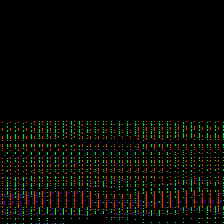

In [34]:
for (index, each_video) in enumerate(image_list):
  for (image_index, each_frame) in enumerate(each_video):
    for idx, frm in enumerate(each_frame):      
      os.chdir(train_path)
      im = Image.fromarray(np.asarray(frm)*64, 'RGB')
im.show()


In [3]:
train_images = os.listdir('/content/drive/MyDrive/UCF-101/train')


In [18]:
frm

NameError: ignored

In [5]:
print(train_images[:4])

['v_BandMarching_g14_c02_0_0.jpg', 'v_BandMarching_g14_c02_0_1.jpg', 'v_BandMarching_g14_c02_0_2.jpg', 'v_BandMarching_g14_c02_0_3.jpg']


In [13]:
image_array = []
image_name  = []
y_train     = []
labels = {'BandMarching':0,'ApplyEyeMakeup':1,'Basketball':2,'BaseballPitch':3,'BabyCrawling':4}
for images in tqdm(train_images):
    


    # Load the InceptionV3 model pre-trained on ImageNet
    model = InceptionV3(weights='imagenet', include_top=True)

    # Load the image
    img = tf.keras.preprocessing.image.load_img(f'/content/drive/MyDrive/UCF-101/train/{images}', target_size=(299, 299))

    # Convert the image to a NumPy array
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Expand the dimensions of the array to match the input shape of the model
    img_array = tf.expand_dims(img_array, axis=0)

    # Preprocess the image
    img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)

    # Pass the image through the model to get the output
    output = model.predict(img_array)

    # Get the last layer of the output
    last_layer = output[-1]
    
    image_array.append(last_layer)
    image_name.append(images)
    
    y_train.append(labels[images.split('_')[1]])  ### class label append

  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 3s 3s/step


In [9]:
# labels = {'BandMarching':0,'ApplyEyeMakeup':1,'Basketball':2,'BaseballPitch':3,'BalanceBeam':4}

In [8]:
X_train = np.stack(image_array)# COnvert to nparray list of list to array of arrays

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
targets = ohe.fit_transform(y_train.reshape(-1,1))

In [9]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Dropout

In [10]:
num_classes = 5
model = Sequential([
    LSTM(512, input_shape=(1000, 1), activation='relu'),
    Dense(100, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), targets,
          batch_size=32,
          epochs=50,)

In [ ]:
# for category in os.listdir(labels_path):
#     if "train" in category:
#       train_file = open(category, 'r')
#       for line in train_file:
#         print(line)

classInd.txt
testlist01.txt
testlist02.txt
testlist03.txt
trainlist01.txt
trainlist02.txt
trainlist03.txt


In [ ]:
# path=[]
# for label in labels:
#     path.append(images_path + label +"/")
# path[0]

In [ ]:
# # image_list, train_label = get_frames(4)

# def plot_images(image_list,train_label, save = False):
#   """
#   Plotting the Images with their training labels
#   Each Video will generate 5 frames and each frame is plotted
#   """
#   fig, axes = plt.subplots(len(image_list), 5, figsize = (25,20))
#   for (index, each_video) in enumerate(image_list):
#     for (image_index, each_frame) in enumerate(each_video):
#       for idx, frm in enumerate(each_frame):
#         axes[index][idx].imshow(frm, interpolation = 'nearest')
#         axes[index][idx].set_title(train_label[index], fontdict={'fontsize': 15, 'fontweight': 'medium'})
#   return None


In [ ]:
# """
# Plotting images and the lables from training videos
# """
# image_list = []
# training_labels = []
# for vdo in train["vdo"][np.random.randint(0,1000,5)]:
#   image, label = get_frames_for_video(vdo)
#   image_list.append(image)
#   training_labels.append(label)
# plot_images(image_list, training_labels)


'\nPlotting images and the lables from training videos\n'

In [ ]:
# """ Call to the load_videos"""
# def get_frames(num_videos = 5):
#   """
#   This method accepts the number of videos to call load_vidoes for and get the frames for videos
#   and returns a list of images with their frames and the training labels
#   """
#   image_list = []
#   training_label = []
#   for vdo in train["vdo"][np.random.randint(0,1000,num_videos)]: # Any random 5 videos
#     # Call to load_videos
#     img = load_videos(os.path.join(base_path,vdo)) 
#     image_list.append(img)
#     training_label.append(train.loc[train.vdo == vdo,'class'].item())
#   return image_list, training_label

In [ ]:
"""
Populate  Images from Train and test Videos in different folders
"""
for vdo in train["vdo"]:
  print(vdo)

In [ ]:

# def load_videos(data_dir):
#   label_index = 0
#   labels = []
#   images = []

#   for folder in data_dir:
#     # print("folder: ", folder )
#     for video in tqdm(os.listdir(folder)):
      
#       video_path = os.path.join(folder, video)
#       # print("video_path:", video_path)
#       frames_list = images_from_video(video_path)
#       print(f"Video: {video}, Frames: {len(frames_list)}")
#       images.append(frames_list)
#       labels.append(label_index)
#     label_index += 1

#   return np.array(images), np.array(labels, dtype = 'int8')


In [ ]:
# images, labels = load_videos(videos_path[1:2])

In [ ]:
# load_videos(os.path.join(base_path,"ApplyLipstick/v_ApplyLipstick_g02_c02.avi"))

In [ ]:
# labels = []
# videos_path = []
# for label in os.listdir(base_path):
#   labels.append(label)
#   videos_path.append(base_path+'/'+label+'/')
# labels.sort()
# videos_path.sort()

In [ ]:
# rec = cv2.VideoCapture("/content/drive/MyDrive/UCF-101/ApplyLipstick/v_ApplyLipstick_g02_c02.avi")

In [ ]:
# rec.get(cv2.CAP_PROP_FRAME_COUNT)

In [ ]:
# rec.set(cv2.CAP_PROP_POS_FRAMES, 8 * 10)

In [ ]:
# rec.read()[0]

In [ ]:
# pix = cv2.resize(rec.read()[1], (240,240))

In [ ]:
# from matplotlib import pyplot as plt
# plt.imshow(pix, interpolation='nearest')
# plt.show()
